In [130]:
import os
os.chdir(r'C:\Users\Navid\Documents\ds_salary_proj')

In [131]:
#!conda install seaborn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [132]:
df = pd.read_csv('df_salary')

In [133]:
df = df.reset_index(drop=True)

## Cleaning the salary data

In [134]:
df['salary_type'] = df['Salary Range'].apply(lambda x: x.split()[1] if 'Employer Provided Salary' not in x 
                                            else x.split('\n')[0])

In [135]:
df['Salary Range'] = df['Salary Range'].apply(lambda x: x.split("\n")[0] if 'Employer Provided Salary' not in x 
                                              else x.split('\n')[1])

In [136]:
df['Salary Range'] = df['Salary Range'].apply(lambda x: x.split()[0] if 'per hour' in x.lower() 
                                              else x)

In [137]:
print(df['salary_type'].unique())

['(Glassdoor' '(Employer' 'Per' 'Employer Provided Salary:\r'
 'Employer Provided Salary:']


In [138]:
df['per_hour'] = [1 if 'Per' in x else 0 for x in df['salary_type']]
df['Employer_reported'] = df['salary_type'].apply(lambda x: 1 if 'employer' in x.lower() else 0)

In [139]:
#extracting avg salary from slaray estimation
df['avg_salary'] = (df['Salary Range'].map(lambda x: x.split('-')[0].lstrip('$').rstrip('k\r')).astype('int32')
                    +df['Salary Range'].map(lambda x: x.split('-')[1].lstrip('$').rstrip('k\r')).astype('int32'))/2

In [140]:
#now lets find the avg salary of those reported per hour
#we multiply them by 2000 (approximately the number of hourse per year) and devide by 1000 (therefore, we just multiply it by 2)
df['avg_salary'] = df.apply(lambda x: x.avg_salary if x.per_hour != 1 else x.avg_salary*2,axis=1)

## Lets extract the name of the companies

In [141]:
df.loc[df['Rating'] == -1, 'Company Name']
# it seems that the companies without rating, only have their name in the Company Name column

267     Penn State Health Milton S. Hershey Medical Ce...
558                               Intellitech Corporation
637                                      Fulcrum Concepts
1024    Penn State Health Milton S. Hershey Medical Ce...
1505                         PLI Card Marketing Solutions
Name: Company Name, dtype: object

In [142]:
df['Company Name'] = df.apply(lambda x: x['Company Name'] if x['Rating'] == -1 else x['Company Name'].split("\n")[0] , axis = 1)

In [143]:
#Adding a fature for FAANG companies
df['FAANG'] = df['Company Name'].apply(lambda x: 1 if x in ['Facebook','Amazon','Netflix','Apple','Google'] else 0)

## Extracting the states from the locations

In [144]:
# Since in Location columns there are instacnes wuth differnt structre, such as 'Virgina', we need to replace them with 
# the same structure as others so that we can extract usefull info from them

# We remove the ones without specified location (United States)
df = df[df['Location'] != 'United States']
list_1 = []
for item in df.Location:
    if ',' not in item:
        list_1.append(item)

set(list_1)

{'Remote'}

In [145]:
df['state'] = df.apply(lambda x: x['Location'] if ',' not in x['Location']
                       else x['Location'].split(',')[1].lstrip() , axis = 1)
# we create a dict to use for mapping
state_convertor = {'Colorado' : 'CO' , 'Georgia' : 'GA' , 'Missouri' : 'MO' , 'New Jersey' : 'NJ' ,
             'Remote' : 'Remote' , 'Utah' : 'UT' , 'Virginia' : 'VA' , 'California' : 'CA' , 'Pennsylvania' : 'PA' ,
                'Puerto Rico' : 'PR' , 'Texas' : 'TX' , 'Illinois' : 'IL' }
df['state'] = df['state'].apply(lambda x: state_convertor[x] if x in state_convertor else x)

In [147]:
# Now we want to change the founded year to age of the company
df['Founded'] = df['Founded'].apply(lambda x: -1 if x == -1 else 2020 - x)

In [148]:
#the length of the job description can be a usefull feature
df['desc_length'] = df['Job Description'].apply(lambda x: len(x))

## Job Titles Simplifier
## Extracting Seniority

In [149]:
df['Job Title'].value_counts()[:40]

Data Analyst                                           207
Data Scientist                                         105
Data Engineer                                           80
Senior Data Engineer                                    31
Senior Data Scientist                                   26
Machine Learning Engineer                               23
Senior Data Analyst                                     18
Software Engineer                                       17
Data Architect                                          15
Lead Data Scientist                                     10
Lead Data Engineer                                       9
Principal Data Scientist                                 8
Business Intelligence Analyst                            8
Marketing Data Analyst                                   7
Data Analyst II                                          6
Data Governance Analyst                                  6
Senior Machine Learning Engineer                        

In [150]:
# job title convertor
def title_extractor(title):
    if 'data scientist' in title.lower() or 'data science' in title.lower():
        return 'data scientist'
    elif 'data analyst' in title.lower() or 'marketing data analyst' in title.lower() or 'business intelligence analyst' in title.lower() or 'quantitative analyst' in title.lower() or 'analytic' in title.lower():
        return 'data analyst'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'machine learning engineer' in title.lower():
        return 'machine learning engineer'
#     elif 'software engineer' in title.lower():
#         return 'software engineer'
    elif 'data architect' in title.lower():
        return 'data architect'
#     elif 'research scientist' in title.lower():
#         return 'research scientist'
#     elif 'lab scientist' in title.lower() or 'labratory scientist' in title.lower():
#         return 'lab scientist'
    else:
        return 'na'
    
    

In [151]:
# seniority extractor
def seniority(title):
    if 'senior' in title.lower() or 'sr' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower() or 'sr.' in title.lower() or 'ii' in title.lower():
        return '1'
#     elif 'jr' in title.lower() or 'jr.' in title.lower() or 'junior' in title.lower():
#         return 'junior'
    else:
        return '0'
    

In [152]:
df['seniority'] = df['Job Title'].apply(seniority)
df['title'] = df['Job Title'].apply(title_extractor)

In [153]:
df.seniority.value_counts()

0    1222
1     494
Name: seniority, dtype: int64

In [154]:
df.title.value_counts()

data analyst                 575
na                           501
data scientist               384
data engineer                181
data architect                41
machine learning engineer     34
Name: title, dtype: int64

In [155]:
df.loc[df['title']=='na','Job Title']

18                               Bioinformatics Scientist
28      LabVIEW Developer/Architect (Control & Data Ac...
38             Medical Lab Scientist Virtual Hiring Event
46      COMPUTER SCIENTIST - ENGINEER - RESEARCH COMPU...
47                                        STAFF SCIENTIST
                              ...                        
1710                                    Civil Engineer II
1711                                      NetOps Engineer
1713               Adobe Multi-Solution Engineer - Remote
1714                                        Test Engineer
1715          Software Engineer (Polyglot - .NET/C#/Java)
Name: Job Title, Length: 501, dtype: object

In [156]:
# Lets remove irrelevant jobs
df = df[df.title != 'na']

## Defining some new features from the job descriptions

In [157]:
df['python'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df['r studio'] = df['Job Description'].apply(lambda x: 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)
df['ML'] = df['Job Description'].apply(lambda x: 1 if 'machine' in x.lower() or 'ml' in x.lower() else 0)
df['spark'] = df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
df['deep_learning'] = df['Job Description'].apply(lambda x: 1 if 'tensorflow' in x.lower() or 'pytorch' in x.lower() else 0)
df['aws'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() or 'cloud' in x.lower() else 0)


In [158]:
df.ML.value_counts()

0    672
1    543
Name: ML, dtype: int64

## Some work on the industry column

In [159]:
# some work on indsutry columns
manufacturing_list = []
for item in df.Industry:
    if 'manufacturing' in item.lower():
        manufacturing_list.append(item)
df['Industry'] = df['Industry'].apply(lambda x: 'manufacturing' if x in manufacturing_list else x)   
financial_list = ['Brokerage Services', 'Insurance Agencies & Brokerages', 'Financial Transaction Processing' , 
                 'Investment Banking & Asset Management', 'Lending', 'Banks & Credit Unions', 'Financial Analytics & Research']
df['Industry'] = df['Industry'].apply(lambda x: 'financial_related' if x in financial_list else x)
other_industries = df.Industry.value_counts().index[df.Industry.value_counts().values>10]
df['Industry'] = df['Industry'].apply(lambda x: 'other_industries' if x not in other_industries else x)

## Education

In [160]:
# education form job description
df['phd'] = df['Job Description'].apply(lambda x: 1 if ('phd' in x.lower()) or ('doctor' in x.lower())  else 0)
df['undergrad'] = df['Job Description'].apply(lambda x: 1 if 'bachelor' in x.lower() else 0)
df['master'] = df['Job Description'].apply(lambda x: 1 if 'master' in x.lower() else 0)

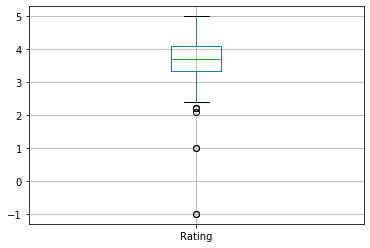

In [161]:
df.boxplot(column = 'Rating')

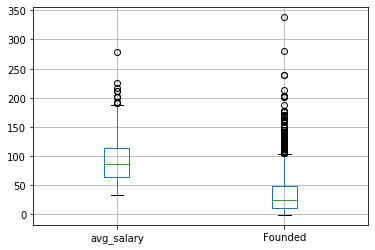

In [162]:
df.boxplot(column = ['avg_salary','Founded'])
# Many outliers for Founded

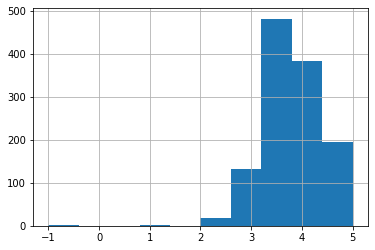

In [163]:
df.Rating.hist()
#pretty much normalized

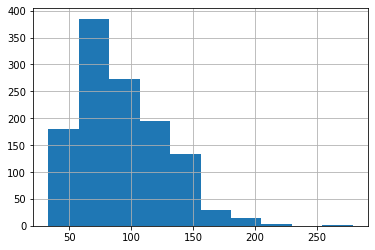

In [164]:
df.avg_salary.hist()
# it seems that the avg_salary data is skewed

In [165]:
df.corr()['avg_salary']

Unnamed: 0          -0.054654
Rating               0.143060
Headquarters              NaN
Founded             -0.082535
Competitors               NaN
per_hour            -0.029031
Employer_reported   -0.022695
avg_salary           1.000000
FAANG                0.106702
desc_length          0.127412
python               0.362701
r studio            -0.062848
ML                   0.303734
spark                0.221771
deep_learning        0.222182
aws                  0.198877
phd                  0.211802
undergrad           -0.229446
master               0.080329
Name: avg_salary, dtype: float64

In [166]:
df_cat = df[['Company Name','Location','Type of ownership', 'Industry', 'Sector','state','seniority',
               'title', 'python', 'r studio', 'ML', 'spark', 'deep_learning','Size']]

graph is Company Name , and the total number is 15


E:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


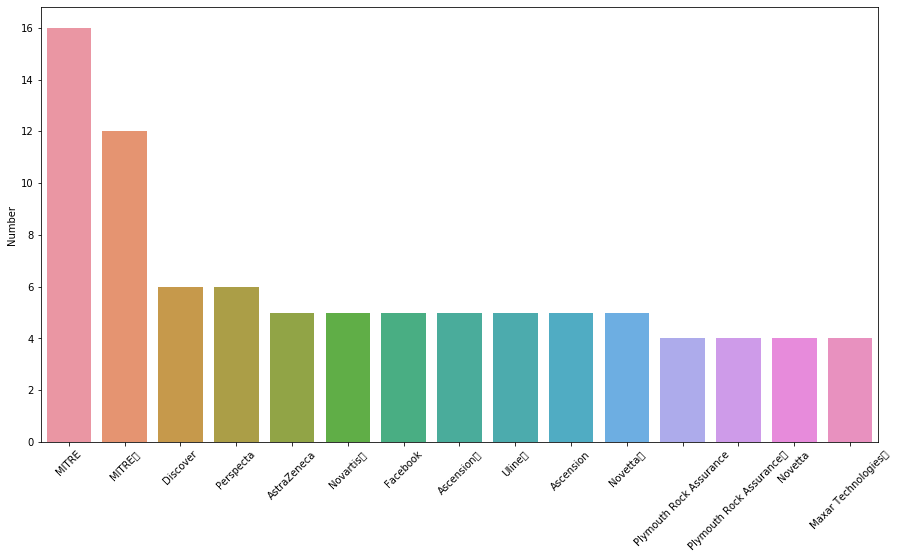

graph is Location , and the total number is 15


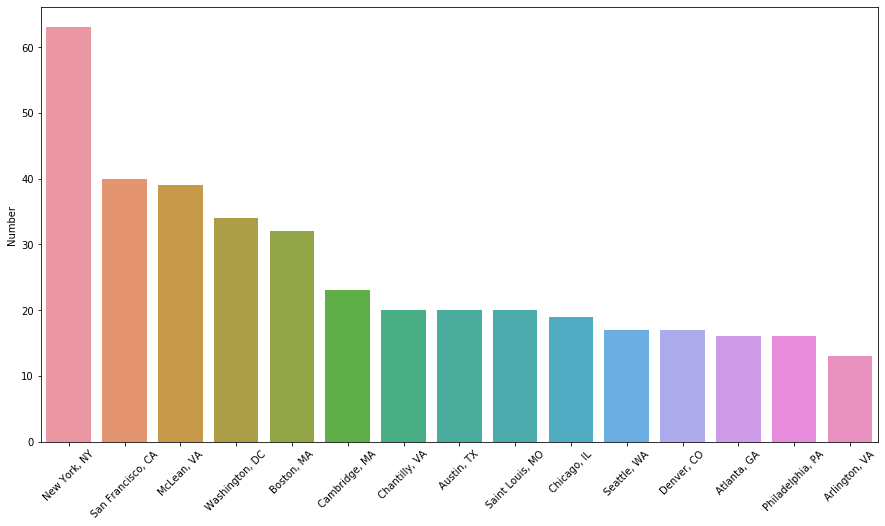

graph is Type of ownership , and the total number is 10


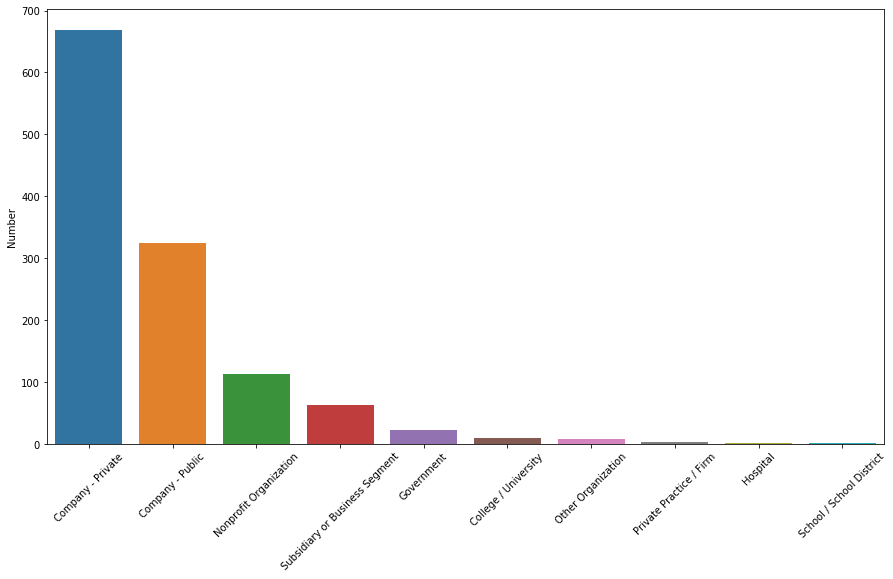

graph is Industry , and the total number is 15


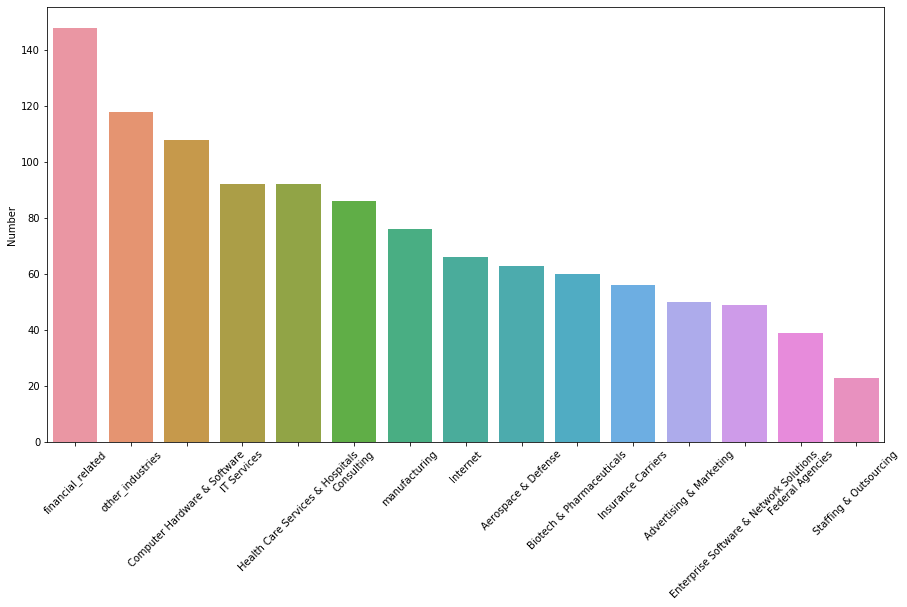

graph is Sector , and the total number is 15


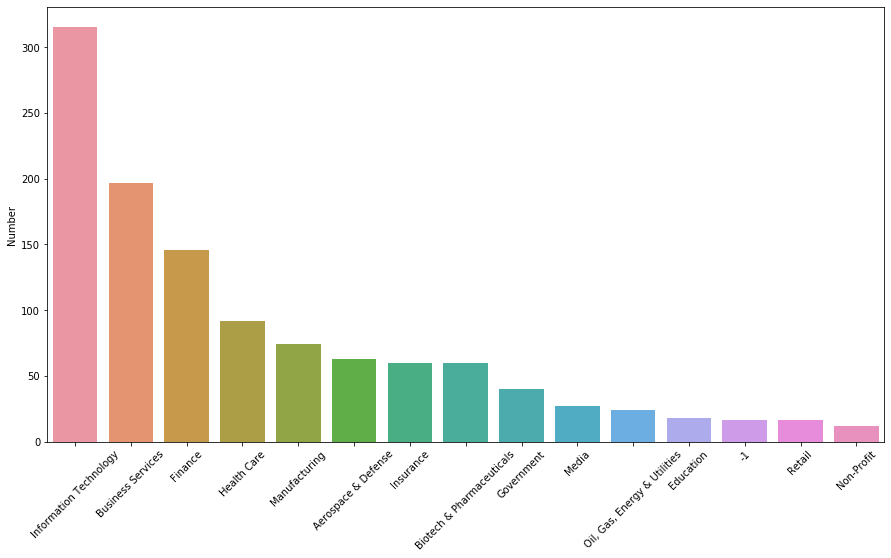

graph is state , and the total number is 15


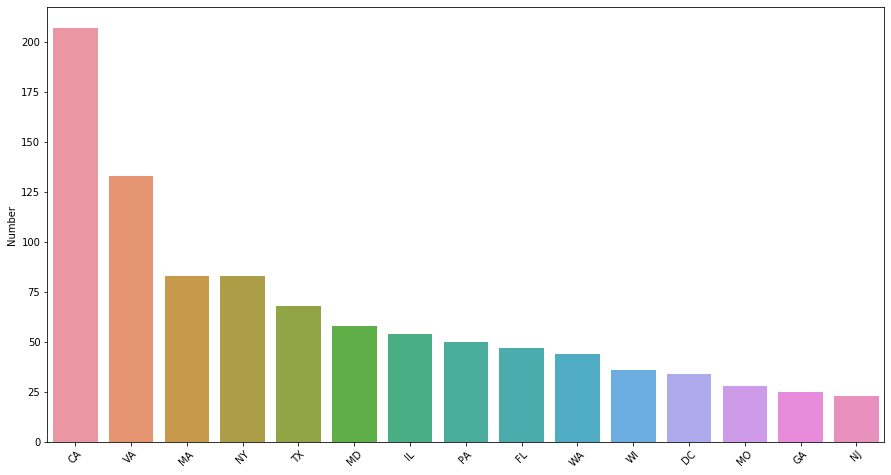

graph is seniority , and the total number is 2


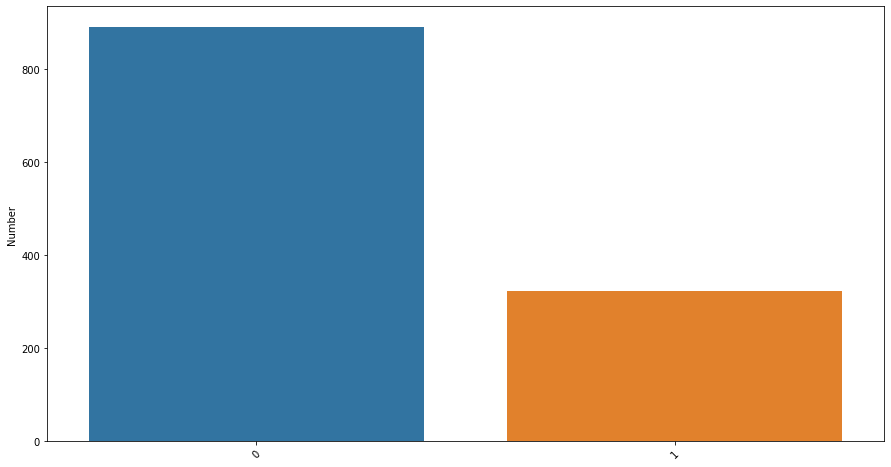

graph is title , and the total number is 5


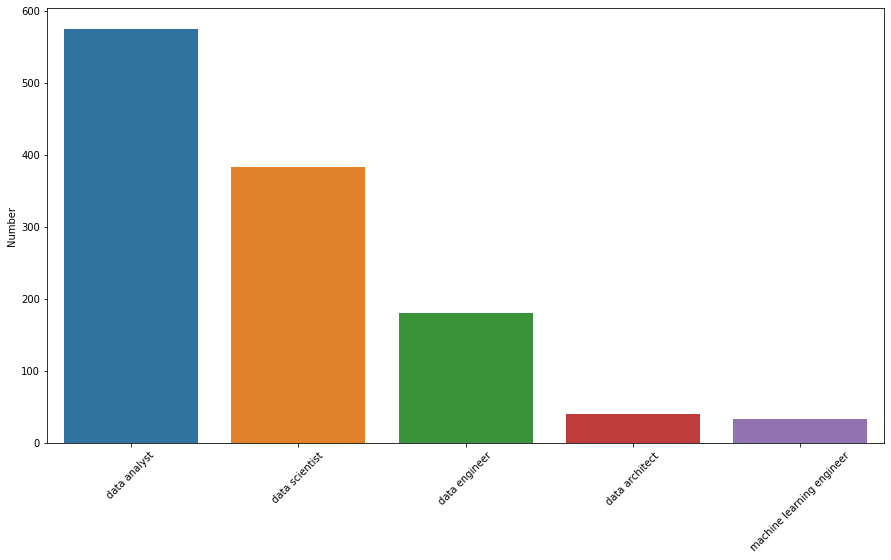

graph is python , and the total number is 2


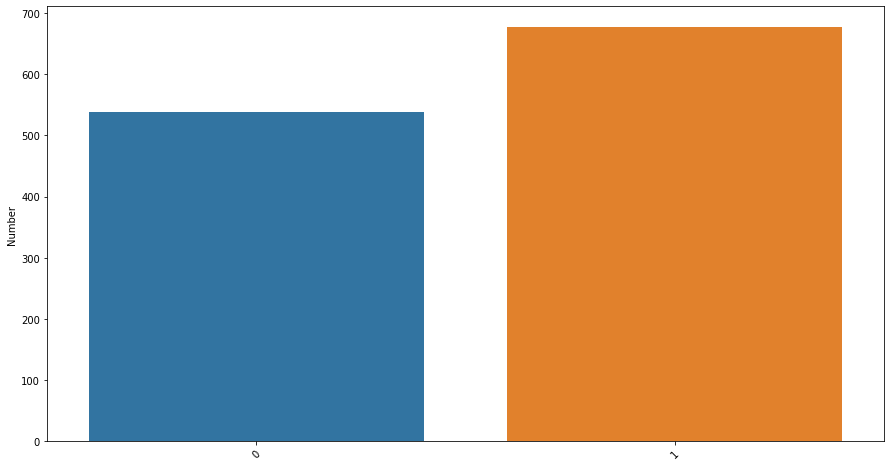

graph is r studio , and the total number is 2


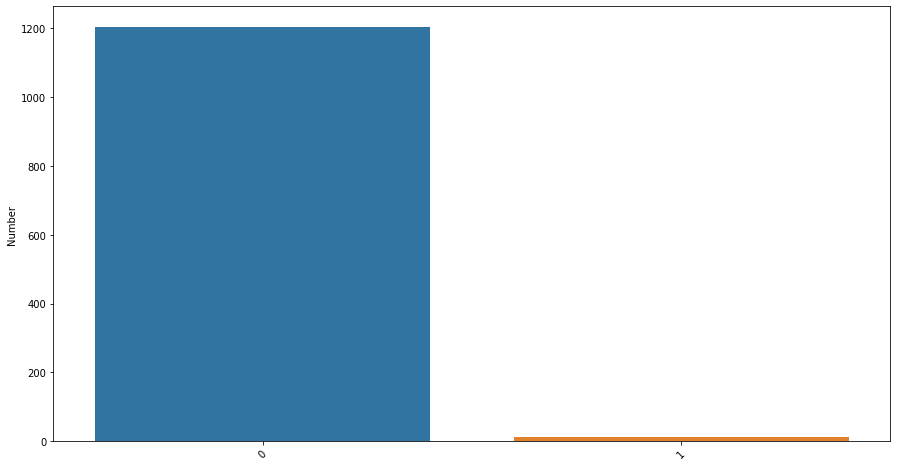

graph is ML , and the total number is 2


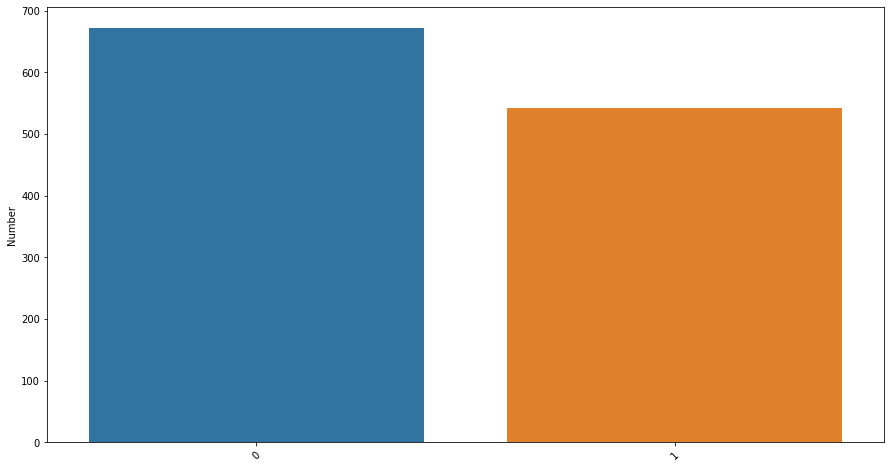

graph is spark , and the total number is 2


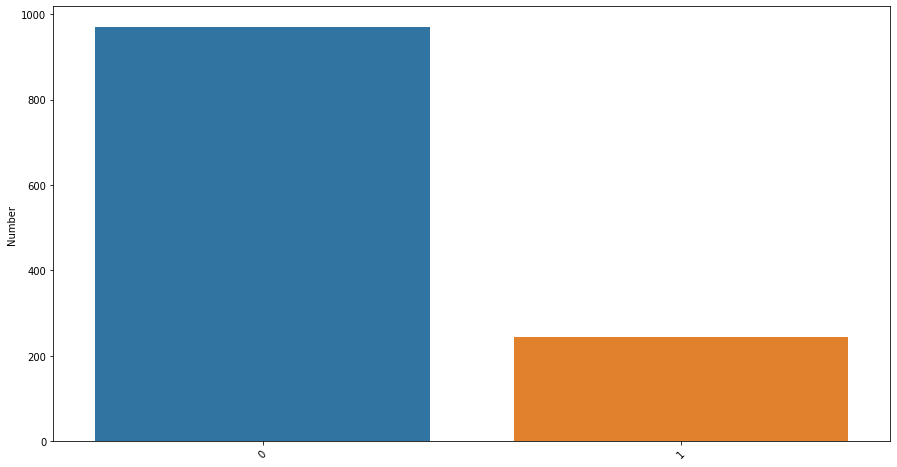

graph is deep_learning , and the total number is 2


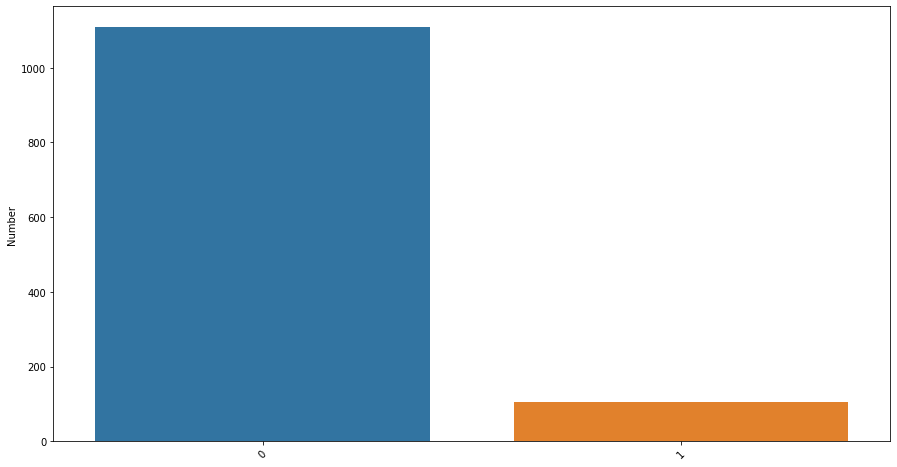

graph is Size , and the total number is 8


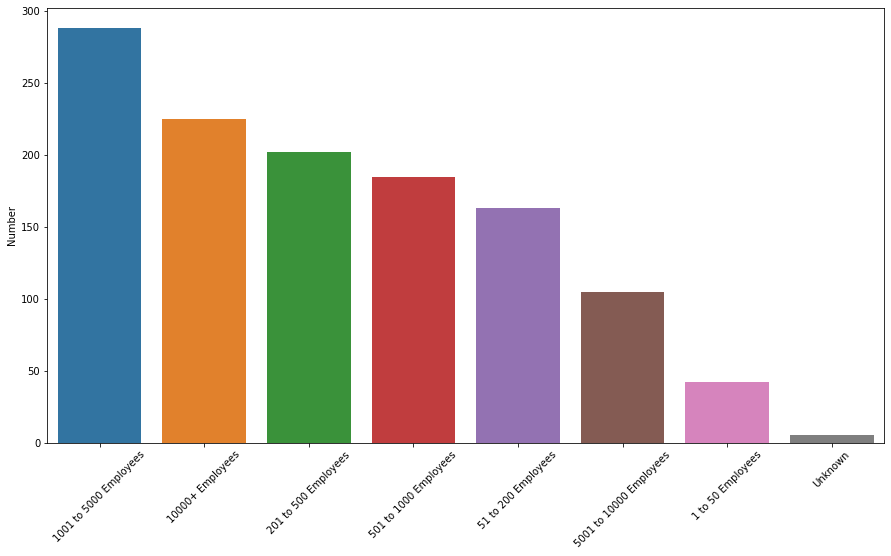

In [167]:
#lets draw some bar graphs for the categorical features
for i in df_cat.columns:
    plt.figure(figsize = (15,8))
    cat_num = df_cat[i].value_counts()[:15]
    print("graph is %s , and the total number is %d" %(i,len(cat_num)))
    ax = sns.barplot(x = cat_num.index , y = cat_num)
    ax.set_xticklabels(ax.get_xticklabels() , rotation = 45)
    ax.set(ylabel = 'Number')
    plt.show()
    

In [168]:
pd.pivot_table(df, index = ['title','seniority'] , values ='avg_salary')
# it is wierd. Seniors are getting paid lower than juniors. Lets take this column out.

avg_salary
title                     seniority            
data analyst              0           64.462306
                          1           87.576613
data architect            0          114.306452
                          1          131.850000
data engineer             0           96.426606
                          1          118.298611
data scientist            0          107.009158
                          1          135.229730
machine learning engineer 0          111.962963
                          1          171.357143

In [169]:
pd.pivot_table(df, index = 'Industry' , values ='avg_salary')

,avg_salary
Industry,
-1,78.500000
Advertising & Marketing,88.580000
Aerospace & Defense,95.841270
Biotech & Pharmaceuticals,114.900000
Colleges & Universities,49.318182
Computer Hardware & Software,102.828704
Consulting,86.924419
Energy,83.840909
Enterprise Software & Network Solutions,109.653061


In [170]:
pd.pivot_table(df, index = 'state' , values ='avg_salary').sort_values('avg_salary',ascending =False)

,avg_salary
state,
CA,116.415459
MA,105.524096
MD,100.896552
AR,100.500000
NJ,99.695652
VA,97.484962
UT,94.541667
IL,93.425926
DC,93.029412


In [171]:
df = df.loc[df.state != 'Los Angeles']

In [43]:
# doing some text analysis on the job description
from wordcloud import WordCloud , STOPWORDS
from nltk.corpus import stopwords;
from nltk.tokenize import word_tokenize
#nltk.download('all')

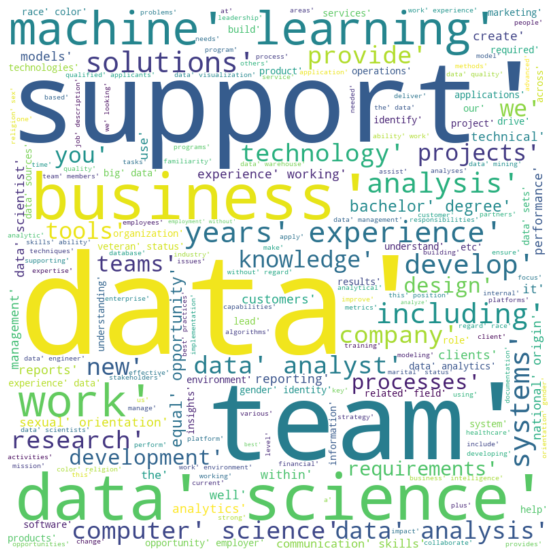

In [44]:
words = " ".join(df['Job Description'])
def pucntuation_remover(input_text):
    filtered = []
    word_token = word_tokenize(input_text)
    stop_words = set(stopwords.words('english'))
    for i in word_token:
        if i not in stop_words and i.isalpha():
            filtered.append(i.lower())
    return filtered
text = pucntuation_remover(words)
wc = WordCloud(width = 800 , height = 800 , background_color = 'white' , stopwords = STOPWORDS)
wc.generate(str(text))
plt.figure(figsize  = (10,10))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.show()

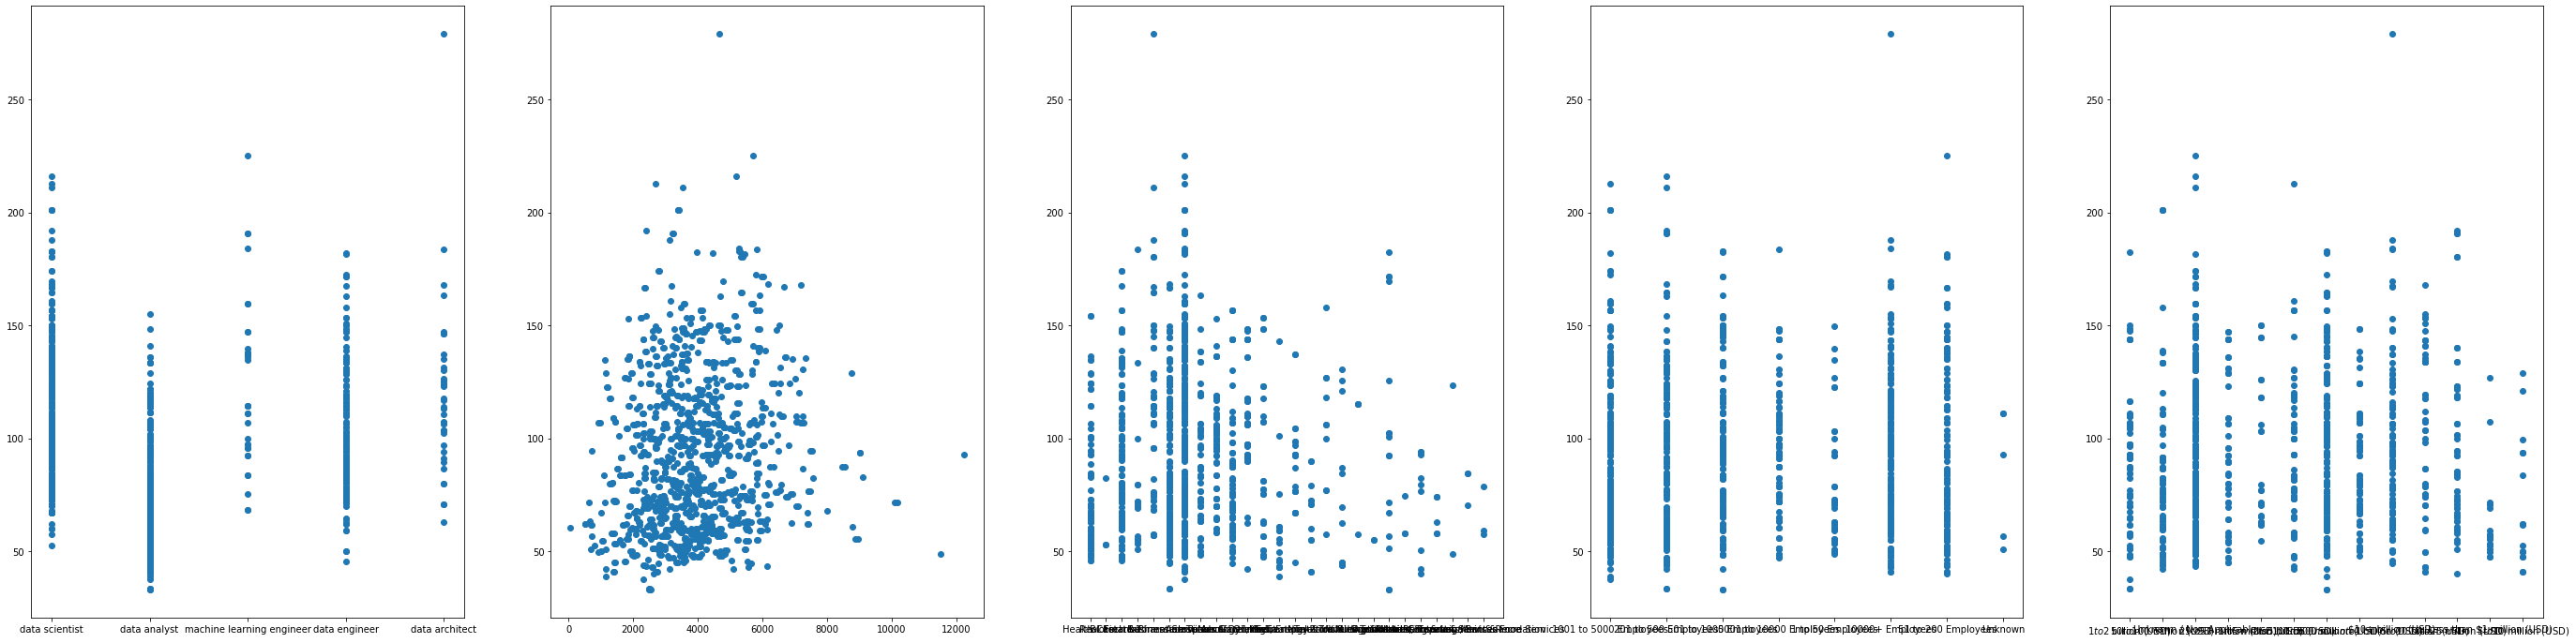

In [173]:
fig , (ax1, ax2, ax3 , ax4 , ax5) = plt.subplots(1,5 , figsize = (48,12))
ax1.scatter(df['title'],df['avg_salary'])
ax2.scatter(df['desc_length'],df['avg_salary'])
ax3.scatter(df['Sector'],df['avg_salary'])
ax4.scatter(df['Size'],df['avg_salary'])
ax5.scatter(df['Revenue'],df['avg_salary'])

In [176]:
import re

# Lets see how many years of experience each job needs

In [ ]:
df_exp = df['Job Description'].str.extractall(r'\(?(\d?\d)\+?\)? (?:Y|y)ear')
df_exp.rename(columns = {0:'exp_year'},inplace=True)
df_exp['exp_year'].fillna(0,inplace=True)
df_exp.reset_index('match',inplace=True)
df_exp['exp_year'] = df_exp['exp_year'].astype('int32')
df_exp.drop('match',axis=1,inplace=True)
df_exp['exp_year'].hist()

In [209]:
# There are some wierd numbers in years of exp. Lets check anything greater than 10
print(df_exp[df_exp['exp_year']>10])

      exp_year
1           25
9           55
10          40
23          14
29          35
...        ...
1586        12
1625        50
1638        20
1656        12
1667        12

[96 rows x 1 columns]


In [212]:
#Lets remove any years of expereicne more than 14 
df_exp = df_exp[df_exp['exp_year']<15]

In [218]:
df_exp2 =  df_exp.groupby(df_exp.index)['exp_year'].mean()

In [219]:
df2 = pd.merge(df,df_exp2, left_index = True, right_index =True, how = 'left') 

In [221]:
df2['exp_year'].fillna(0,inplace=True)

## Lets Export the final data frame

In [223]:
# df = df.loc[df.avg_salary > 40]
df2.to_csv('eda_data_modified')